In [1]:
import numpy as np
import pandas as pd
import json
from scipy.signal import find_peaks
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

import scanpy as sc
import squidpy as sq

import model.utilities as utils
from model.slide_utilities import *

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Read DeepSPACE adata
slide = 1
sample = 'x1'

adata = sc.read_h5ad(f"adata/Result_slide_{slide}_sample_{sample}.h5ad")

# add cluster markers
cols = adata.obs.columns
resolutions = [col for col in cols if col.find("leiden_") > -1]

enrichment = []
resolutions_limited = resolutions[5:20]
for res in resolutions_limited:
    cluster2marker = add_markers(adata, 
                        markers = KidneyCellMarkers, 
                        groupby = res,
                        colormap = colormap,
                        marker_subset = marker_subset, 
                        keyadded = 'final_clusters',
                        verbos=False,
                        return_adata = False
                       )
    enrichment.append(list(cluster2marker.values())[0]['diff'])

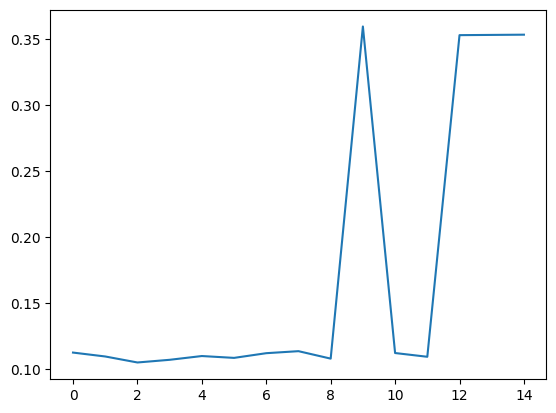

'leiden_0.15'

In [11]:
enrichment = np.array(enrichment)
resolutions_limited = np.array(resolutions_limited)
d_enrichment = enrichment[1:-1] - enrichment[0:-2]

sns.lineplot(enrichment)
plt.show()

top1 = np.where(enrichment == enrichment.max())
resolutions_limited[top1].item()

half of the window is: [1.00000005e+00 7.07106852e-01 3.16227766e-04]


'leiden_0.08'

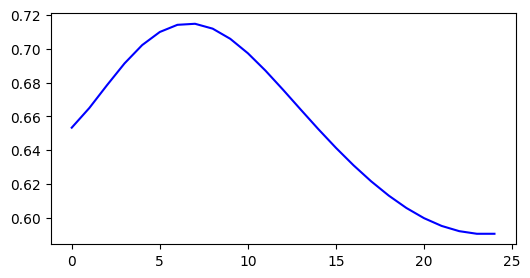

In [12]:
# Clustering robustness
Clusters = []
resolutions_limited_2 = resolutions[0:25]
for res in resolutions_limited_2:
    Clusters.append(adata.obs[res])
ARI_avg = utils.windowed_ari(Clusters, window_len_half = 3)

# Plot ARI
fig, ax = plt.subplots(figsize=(6, 3))
plt.plot(ARI_avg, color='blue')

top2 = find_peaks(ARI_avg)[0].item()
resolutions_limited_2[top2]

Cluster nymber to marker dict:
{'4': {'set': 'Glom. Podocytes', 'max': 0.11256644, 'diff': 0.11231716782885887}, '0': {'set': 'Prox. Tubule', 'max': 0.21819377, 'diff': 0.215078432932508}, '5': {'set': 'DistaL Con. Tubule', 'max': 0.31013882, 'diff': 0.26448421498681923}}


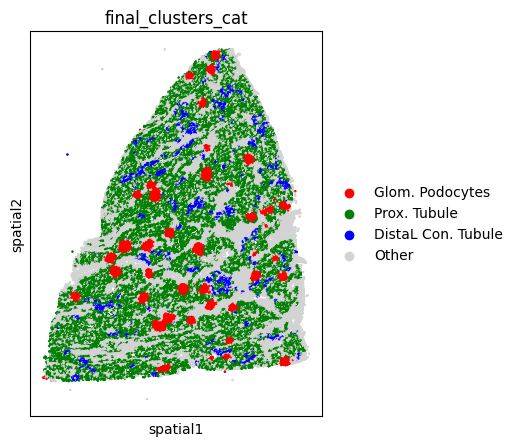

In [5]:
# resolution_best = resolutions_limited[top1].item()
# resolution_best = resolutions_limited_2[top2]
resolution_best = 'leiden_0.12'
# adata = sc.read_h5ad(f"adata/Result_slide_{slide}_sample_{sample}.h5ad")

# add cluster markers
adata = add_markers(adata, 
                    markers = KidneyCellMarkers, 
                    groupby = resolution_best,
                    colormap = colormap,
                    marker_subset = marker_subset, 
                    keyadded = 'final_clusters'
                   )

# spatial plot
fig, ax = plt.subplots(figsize=(5, 5))
sq.pl.spatial_scatter(
    adata,
    library_id="spatial",
    shape=None,
    color=['final_clusters_cat'],
    wspace=0.1,
    ax = ax
)

plt.savefig('your_plot_name.pdf', bbox_inches='tight')

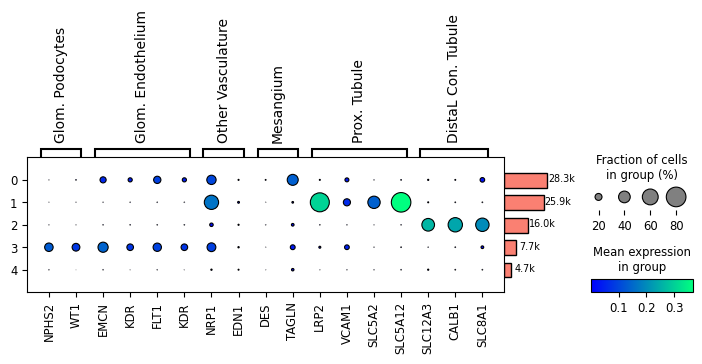

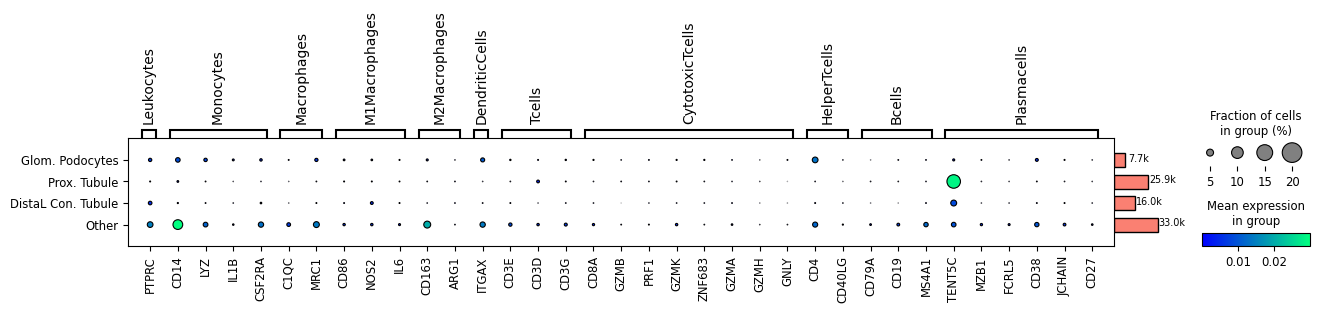

In [16]:
Markers = remove_extra_genes(KidneyCellMarkers, adata)
dp = sc.pl.dotplot(adata, Markers, groupby=resolution_best, use_raw=False, return_fig=True)
dp.style(dot_edge_color='black', dot_edge_lw=.8)
dp.add_totals()
# dp.savefig("marker.pdf")
dp.show()

# Immunological enrichment
Markers = remove_extra_genes(ImmuneMarkers, adata)
dp = sc.pl.dotplot(adata, Markers, groupby='final_clusters_cat', use_raw=False, return_fig=True)
dp.style(dot_edge_color='black', dot_edge_lw=.8)
dp.add_totals()
dp.show()

## All in a loop

In [33]:
with open("annotations/slides_patients_annotation.json", 'r') as file:
    slide_info = json.load(file)
sample_info = slide_info['sample_info']

In [97]:
resolution_enrichment = dict()
resolution_stability = dict()

for slide in [1, 3, 4, 5, 6, 7, 8]:
    print(slide)
    
    for sample, label in sample_info[f'slide_{slide}']['label'].items():
        print(sample)

        adata = sc.read_h5ad(f"adata/Result_slide_{slide}_sample_{sample}.h5ad")

        # add cluster markers
        cols = adata.obs.columns
        resolutions = [col for col in cols if col.find("leiden_") > -1]

        # Find the best enrichment
        enrichment = []
        resolutions_limited = resolutions[5:20]
        for res in resolutions_limited:
            cluster2marker = add_markers(adata, 
                                markers = KidneyCellMarkers, 
                                groupby = res,
                                colormap = colormap,
                                marker_subset = marker_subset, 
                                keyadded = 'final_clusters',
                                verbos=False,
                                return_adata = False
                               )
            enrichment.append(list(cluster2marker.values())[0]['diff'])

        enrichment = np.array(enrichment)
        resolutions_limited = np.array(resolutions_limited)
        top1 = np.where(enrichment == enrichment.max())[0][0]
        
        resolution_best = resolutions_limited[top1].item()
        adata = add_markers(adata, 
                            markers = KidneyCellMarkers, 
                            groupby = resolution_best,
                            colormap = colormap,
                            marker_subset = marker_subset, 
                            keyadded = 'final_clusters',
                            verbos = False
                           )
        fig, ax = plt.subplots(figsize=(5, 5))
        sq.pl.spatial_scatter(
            adata,
            library_id="spatial",
            shape=None,
            color=['final_clusters_cat'],
            wspace=0.1,
            ax = ax
        )
        plt.savefig(f"glom_figs/slide_{slide}_sample_{sample}_{resolution_best}_enrichment.pdf", bbox_inches='tight')
        plt.close(fig)
        resolution_enrichment[sample] = resolution_best
        
        # Clustering robustness
        Clusters = []
        resolutions_limited_2 = resolutions[0:25]
        for res in resolutions_limited_2:
            Clusters.append(adata.obs[res])
        ARI_avg = utils.windowed_ari(Clusters, window_len_half = 3)

        try:
            top2 = find_peaks(ARI_avg)[0].item()
        except:
            top2 = 14 # 'leiden_0.15',
        resolutions_limited_2[top2]

        resolution_best = resolutions_limited_2[top2]
        adata = add_markers(adata, 
                            markers = KidneyCellMarkers, 
                            groupby = resolution_best,
                            colormap = colormap,
                            marker_subset = marker_subset, 
                            keyadded = 'final_clusters',
                            verbos = False
                           )
        fig, ax = plt.subplots(figsize=(5, 5))
        sq.pl.spatial_scatter(
            adata,
            library_id="spatial",
            shape=None,
            color=['final_clusters_cat'],
            wspace=0.1,
            ax = ax
        )
        plt.savefig(f"glom_figs/slide_{slide}_sample_{sample}_{resolution_best}_stability.pdf", bbox_inches='tight')
        plt.close(fig)
        resolution_stability[sample] = resolution_best

1
x1
half of the window is: [1.00000005e+00 7.07106852e-01 3.16227766e-04]
x2
half of the window is: [1.00000005e+00 7.07106852e-01 3.16227766e-04]
x3
half of the window is: [1.00000005e+00 7.07106852e-01 3.16227766e-04]
x4
half of the window is: [1.00000005e+00 7.07106852e-01 3.16227766e-04]
x5
half of the window is: [1.00000005e+00 7.07106852e-01 3.16227766e-04]
x6
half of the window is: [1.00000005e+00 7.07106852e-01 3.16227766e-04]
x7
half of the window is: [1.00000005e+00 7.07106852e-01 3.16227766e-04]
x8
half of the window is: [1.00000005e+00 7.07106852e-01 3.16227766e-04]
3
x9
half of the window is: [1.00000005e+00 7.07106852e-01 3.16227766e-04]
x10
half of the window is: [1.00000005e+00 7.07106852e-01 3.16227766e-04]
x11
half of the window is: [1.00000005e+00 7.07106852e-01 3.16227766e-04]
x12
half of the window is: [1.00000005e+00 7.07106852e-01 3.16227766e-04]
x13
half of the window is: [1.00000005e+00 7.07106852e-01 3.16227766e-04]
x14
half of the window is: [1.00000005e+00 

In [98]:
resolution = {
    'enrichment' : resolution_enrichment,
    'stability' : resolution_stability
}

In [99]:
# with open("resolutions2.json", 'w') as file:
#     json.dump(resolution, file)

## Conclusions

Acording what we observed:

1. *Glom. Podocytes* is better than *Renal Corpuscle* as the latter is wider and sometimes is enriched in clusters other than the gloms.
2. Stability is better than enrichment.

In [313]:
with open("annotations/resolutions_gloms.json", 'r') as file:
    resolution = json.load(file)
resolution = resolution['stability']

In [319]:
resolution_hand = resolution

## Hand fine tuning 

In [320]:
resolution_hand['x6'] = 'leiden_0.09'
resolution_hand['x9'] = 'leiden_0.09'
resolution_hand['x11'] = None
resolution_hand['x12'] = 'leiden_0.25'
resolution_hand['x15'] = 'leiden_0.25'
resolution_hand['x18'] = None
resolution_hand['x19'] = None
resolution_hand['x21'] = 'leiden_0.1'
resolution_hand['x25'] = 'leiden_0.15'
resolution_hand['x27'] = 'leiden_0.15'
resolution_hand['x32'] = 'leiden_0.1'
resolution_hand['x36'] = 'leiden_0.07'
resolution_hand['x42'] = None

Cluster nymber to marker dict:
{'5': {'set': 'Glom. Podocytes', 'max': 0.10801272, 'diff': 0.10682961958864141}, '7': {'set': 'Prox. Tubule', 'max': 0.21320012, 'diff': 0.19095441291441503}, '4': {'set': 'DistaL Con. Tubule', 'max': 0.17608814, 'diff': 0.17087281627997233}}


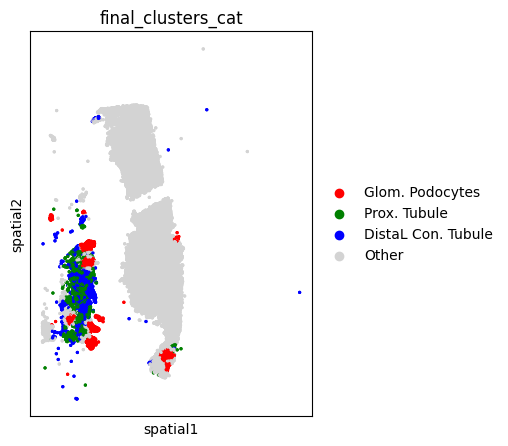

In [322]:
slide = 8
sample = 'x50'

resolution_best = resolution_hand[sample]

adata = sc.read_h5ad(f"adata/Result_slide_{slide}_sample_{sample}.h5ad")

# add cluster markers
adata = add_markers(adata, 
                    markers = KidneyCellMarkers, 
                    groupby = resolution_best,
                    colormap = colormap,
                    marker_subset = marker_subset, 
                    keyadded = 'final_clusters'
                   )

# spatial plot
fig, ax = plt.subplots(figsize=(5, 5))
sq.pl.spatial_scatter(
    adata,
    library_id="spatial",
    shape=None,
    color=['final_clusters_cat'],
    wspace=0.1,
    ax = ax
)

In [324]:
with open("annotations/resolutions_hand_curated_v1.json", 'w') as file:
    json.dump(resolution, file)

In [323]:
resolution_hand

{'x1': 'leiden_0.08',
 'x2': 'leiden_0.15',
 'x3': 'leiden_0.15',
 'x4': 'leiden_0.1',
 'x5': 'leiden_0.09',
 'x6': 'leiden_0.09',
 'x7': 'leiden_0.16',
 'x8': 'leiden_0.15',
 'x9': 'leiden_0.09',
 'x10': 'leiden_0.07',
 'x11': None,
 'x12': 'leiden_0.25',
 'x13': 'leiden_0.17',
 'x14': 'leiden_0.15',
 'x15': 'leiden_0.25',
 'x16': 'leiden_0.12',
 'x17': 'leiden_0.15',
 'x18': None,
 'x19': None,
 'x20': 'leiden_0.15',
 'x21': 'leiden_0.1',
 'x22': 'leiden_0.14',
 'x23': 'leiden_0.1',
 'x24': 'leiden_0.12',
 'x25': 'leiden_0.15',
 'x26': 'leiden_0.17',
 'x27': 'leiden_0.15',
 'x28': 'leiden_0.15',
 'x29': 'leiden_0.08',
 'x30': 'leiden_0.11',
 'x31': 'leiden_0.11',
 'x32': 'leiden_0.1',
 'x33': 'leiden_0.15',
 'x34': 'leiden_0.15',
 'x35': 'leiden_0.16',
 'x36': 'leiden_0.07',
 'x37': 'leiden_0.13',
 'x38': 'leiden_0.15',
 'x39': 'leiden_0.08',
 'x40': 'leiden_0.15',
 'x41': 'leiden_0.15',
 'x42': None,
 'x43': 'leiden_0.08',
 'x44': 'leiden_0.15',
 'x45': 'leiden_0.12',
 'x46': 'leide